# Description
This solution is based on my old code made for Learning to smell challenge.
What it does: uses pubchem's fingerprints, then groups the data in unsupervised manner, after that we take a look at it and

In [1]:
!pip install pubchempy tqdm pandas numpy
!pip install umap-learn scikit-learn

You should consider upgrading via the '/Users/lacemaker/anaconda3/envs/data_env/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/lacemaker/anaconda3/envs/data_env/bin/python3.7 -m pip install --upgrade pip' command.


In [10]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
%matplotlib inline
import pubchempy as pcp
import json
import os
from tqdm import tqdm
import umap
from sklearn.neighbors import NearestNeighbors

In [3]:
# Cell with constants
DATADIR = Path("../data")
RANDOM_SEED = 2407

TMP_DIR = Path("../tmp")
TMP_DIR.mkdir(exist_ok=True)

train_df = pd.read_csv(DATADIR / "train.csv", index_col=0)
test_df = pd.read_csv(DATADIR / "test.csv", index_col=0)

In [4]:
train_df.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [5]:
def get_compounds_fingerprints(df, cache_dir="temp/train", smiles_column="Smiles"):
    """Downloads precomputed fingerprints for compounds from pubchem and saves them to cache.
    Returned cached versions.
    """
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
        # we'll use this directory to cache downloaded fingerprints

    fingerprints = []
    for i in tqdm(df.index, total=df.shape[0]):
        fingerprint_path = os.path.join(cache_dir, f"fingerprint_{i}.json")
        if os.path.exists(fingerprint_path):
            with open(fingerprint_path) as f:
                data = json.load(f)
            fingerprints.append(data)
            continue
        smiles = df.loc[i, smiles_column]
        try:
            compounds = pcp.get_compounds(smiles, 'smiles')
            compound = compounds[0]
        except Exception as e:
            print(f"Got error while loading {i} with smiles string {repr(smiles)}, error: {e}")
            continue

        if compound is None:
            print(f"No compound {i} found, skipping molecule {smiles}" )
            continue
        if compound.fingerprint is None:
            print(f"No fingerprint for molecule {i} is found, skipping" )
            with open(fingerprint_path, 'w') as f:
                data = {
                    smiles_column: smiles,
                    "fingerprint": None
                }
                json.dump(data, f)
        else:
            # cactvs_fingerprint contains the same bits as fingerprint property, 
            # the only difference is representation
            with open(fingerprint_path, 'w') as f:
                data = {
                    smiles_column: smiles,
                    "fingerprint": compound.fingerprint
                }
                json.dump(data, f)

    return fingerprints



In [6]:
## this takes quite some time. 
## For me it takes too long, so I'll run it in google colab and then dowload, unzip and use the results here
train_fingerprints = get_compounds_fingerprints(
    train_df, cache_dir=str(TMP_DIR / "train"))
test_fingerprints = get_compounds_fingerprints(
    test_df, cache_dir=str(TMP_DIR/ "test"))
train_fingerprints_df = pd.DataFrame(train_fingerprints)
test_fingerprints_df = pd.DataFrame(test_fingerprints)


100%|██████████| 1614/1614 [00:01<00:00, 1042.24it/s]


In [7]:
train_df_ext = train_df.merge(train_fingerprints_df, on="Smiles", how="left")
test_df_ext = test_df.merge(test_fingerprints_df, on="Smiles", how="left")
print(train_df_ext.fingerprint.isnull().sum(), "train molecules have no associated fingerprint")
print(test_df_ext.fingerprint.isnull().sum(), "test molecules have no associated fingerprint")


2 train molecules have no associated fingerprint
0 test molecules have no associated fingerprint


In [8]:
def to_bits(x):
    try:
        unpacked = np.unpackbits(np.frombuffer(bytes.fromhex(x), dtype=np.uint8))
    except Exception as e:
        print(e)
        print(x)
        
    return unpacked

train_df_ext = train_df_ext[~train_df_ext.fingerprint.isnull()]
train_fingerprints = train_df_ext.fingerprint.apply(to_bits)#lambda fingerprint_string: [x=='1' for x in fingerprint_string])
train_fingerprints = np.stack(train_fingerprints.values)

test_df_ext = test_df_ext[~test_df_ext.fingerprint.isnull()]
test_fingerprints = test_df_ext.fingerprint.apply(to_bits)#lambda fingerprint_string: [x=='1' for x in fingerprint_string])
test_fingerprints = np.stack(test_fingerprints.values)

In [9]:
embedings = umap.UMAP().fit_transform(train_fingerprints)

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
embedings.shape

(5555, 2)

In [12]:
activities = train_df_ext.Active.values

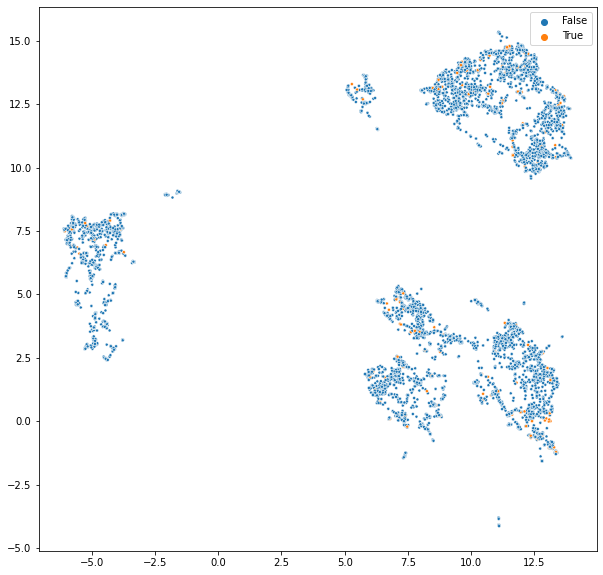

In [25]:
fig = plt.figure(figsize=(10,10))
sns.scatterplot(
    embedings[:, 0], embedings[:, 1], 
    hue=activities, ax=fig.gca(),
    marker='.'
);

In [26]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_fingerprints)
distances, neighbour_indices = nbrs.kneighbors(train_fingerprints)

In [35]:
for i, neighbours in zip(train_df_ext.index, neighbour_indices):
    closest = activities[neighbours]
    train_df_ext.loc[i, "closest"] = closest.mean()

In [37]:
train_df_ext[activities].closest.value_counts()
# seems that it's not a good predictor for this case.

0.2    118
0.4     46
0.6     27
0.8     14
1.0      1
Name: closest, dtype: int64

In [34]:
test_distances, test_neighbour_indices = nbrs.kneighbors(test_fingerprints)

In [38]:
for i, neighbours in zip(test_df_ext.index, test_neighbour_indices):
    closest = activities[neighbours]
    test_df_ext.loc[i, "Activity"] = np.sum(closest) > 0 

In [42]:
test_df_ext.drop(columns=['fingerprint']).to_csv("../tmp/submission_pubchem_fingerprints.csv")